<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/EDA_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória dos dados - Reducing Commercial Aviation Fatalities

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import sys
import os
import math

IN_COLAB = 'google.colab' in sys.modules

In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/reducing-commercial-aviation-fatalities'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [0]:
if IN_COLAB:
    if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
        from google.colab import drive
        drive.mount('/gdrive')

        if os.path.isdir(gdrive_kaggle_dir):
            if os.path.isfile(f'{data_gdrive_dir}/test.csv.zip') and os.path.isfile(f'{data_gdrive_dir}/train.csv.zip'):
                !cp '{data_gdrive_dir}/train.csv.zip' .
                !cp '{data_gdrive_dir}/test.csv.zip' .
            else:
                !mkdir -p ~/.kaggle
                !cp '{api_gdrive_credential_location}' '{api_local_credential_location}'

if not os.path.isfile('train.csv.zip') or not os.path.isfile('test.csv.zip'):
    if os.path.isfile(api_local_credential_location):
        !pip -q install kaggle --upgrade
        !kaggle competitions download -c reducing-commercial-aviation-fatalities
        if IN_COLAB and os.path.isdir(gdrive_kaggle_dir):
            !cp train.csv.zip '{data_gdrive_dir}'
            !cp test.csv.zip '{data_gdrive_dir}'

In [0]:
coluns_types = {
    'crew': 'category',
    'experiment': 'category',
    'seat': 'category',
    'event': 'category'
}

train_df = pd.read_csv('train.csv.zip', dtype = coluns_types)

float64_columns = train_df.select_dtypes(np.float64).columns
train_df[float64_columns] = train_df[float64_columns].astype(np.float16)

In [43]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,23.718750,-6.695312,29.234375,24.843750,3.921875,18.453125,1.075195,3.089844,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75,A
1,1,CA,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,21.015625,-6.476562,26.640625,24.140625,5.468750,20.515625,2.833984,7.101562,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75,A
2,1,CA,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,25.437500,-0.088684,28.125000,26.890625,8.578125,23.156250,4.519531,12.703125,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75,A
3,1,CA,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,19.140625,-0.256592,30.656250,24.250000,8.640625,19.968750,7.277344,11.460938,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75,A
4,1,CA,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,20.578125,-1.953125,31.718750,25.156250,12.500000,18.750000,7.308594,8.007812,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75,A


In [44]:
train_df.describe(include='all')

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
count,4867421,4867421,4.867421e+06,4867421,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4.867421e+06,4867421.0,4867421.0,4867421.0,4867421
unique,9,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,6,DA,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,552958,1658393,NaN,2433939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2848809
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,3.000259e-03,NaN,-1.361000e+03,-1.581000e+03,-1.644000e+03,-1.517000e+03,-1.221000e+03,-1.266000e+03,-1.280000e+03,-1.393000e+03,-2.888000e+03,-1.227000e+03,-2.876000e+03,-1.353000e+03,-4.064000e+03,-2.334000e+03,-1.212000e+03,-1.228000e+03,-1.229000e+03,-1.230000e+03,-6.965000e+02,-1.176000e+03,-18592.0,482.0,0.0,NaN
25%,NaN,NaN,8.806250e+01,NaN,-9.203125e+00,-8.328125e+00,-8.765625e+00,-7.367188e+00,-6.101562e+00,-6.007812e+00,-6.902344e+00,-9.578125e+00,-6.656250e+00,-6.582031e+00,-7.644531e+00,-9.289062e+00,-8.054688e+00,-9.304688e+00,-7.496094e+00,-6.714844e+00,-6.773438e+00,-7.160156e+00,-7.816406e+00,-6.527344e+00,-2550.0,663.0,524.0,NaN
50%,NaN,NaN,1.768750e+02,NaN,3.818359e-01,4.263306e-02,1.140137e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.894043e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.170654e-01,1.106567e-01,5.667114e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5920.0,743.5,770.0,NaN
75%,NaN,NaN,2.682500e+02,NaN,1.030469e+01,8.750000e+00,9.281250e+00,7.437500e+00,6.175781e+00,6.085938e+00,7.070312e+00,1.063281e+01,6.781250e+00,6.746094e+00,7.808594e+00,9.953125e+00,8.632812e+00,9.773438e+00,7.765625e+00,6.832031e+00,6.906250e+00,7.464844e+00,8.023438e+00,6.613281e+00,10288.0,813.5,1197.0,NaN


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          category
experiment    category
time          float16
seat          category
eeg_fp1       float16
eeg_f7        float16
eeg_f8        float16
eeg_t4        float16
eeg_t6        float16
eeg_t5        float16
eeg_t3        float16
eeg_fp2       float16
eeg_o1        float16
eeg_p3        float16
eeg_pz        float16
eeg_f3        float16
eeg_fz        float16
eeg_f4        float16
eeg_c4        float16
eeg_p4        float16
eeg_poz       float16
eeg_c3        float16
eeg_cz        float16
eeg_o2        float16
ecg           float16
r             float16
gsr           float16
event         category
dtypes: category(4), float16(24)
memory usage: 241.4 MB


In [46]:
train_df.isna().sum()

crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

In [47]:
train_df.set_index()

TypeError: ignored

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

train_df.crew.value_counts().sort_index().plot.bar(ax=ax[0], color=sns.color_palette());
train_df.experiment.value_counts().sort_index().plot.bar(ax=ax[1], color=sns.color_palette());
train_df.event.value_counts().sort_index().plot.bar(ax=ax[2], color=sns.color_palette());
train_df.seat.value_counts().sort_index().plot.bar(ax=ax[3], color=sns.color_palette());

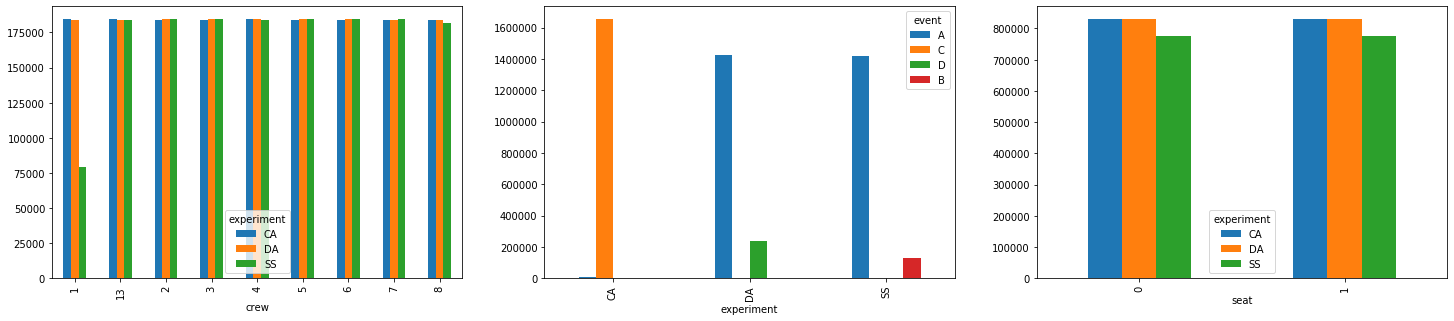

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))

train_df.groupby('experiment').crew.value_counts().unstack(0).sort_index().plot.bar(ax=ax[0]);
train_df.groupby('event').experiment.value_counts().unstack(0).sort_index().plot.bar(ax=ax[1]);
train_df.groupby('experiment').seat.value_counts().unstack(0).sort_index().plot.bar(ax=ax[2]);

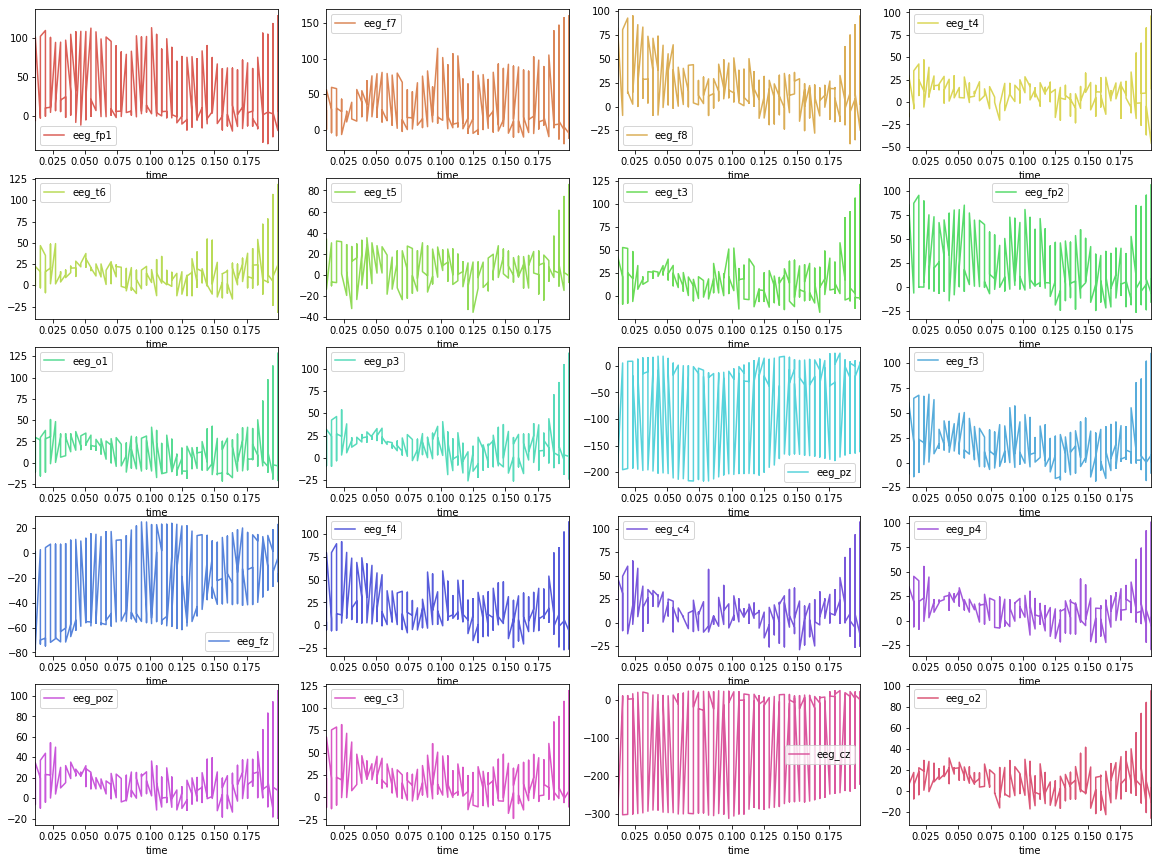

In [49]:
# train_df.loc[(train_df.crew == '1') & train_df.time.between(0, 1), train_df.columns.str.contains('eeg_')].plot()

# sns.FacetGrid(train_df.loc[(train_df.crew == '1') & train_df.time.between(0, 1), train_df.columns.str.contains('eeg_|time')], col="time", palette="tab20c", col_wrap=4, height=1.5)

eeg_cols = train_df.columns[train_df.columns.str.contains('eeg_')]
fig, ax = plt.subplots(math.ceil(eeg_cols.size / 4), 4, figsize=(20, 15))
c = sns.color_palette("hls", eeg_cols.size)
for ix, col in enumerate(eeg_cols):
    train_df.loc[(train_df.crew == '1') & train_df.time.between(0, 0.2), ['time', col]].set_index('time').sort_index().plot(ax=ax[ix // 4, ix % 4], color=c[ix], legend=True);


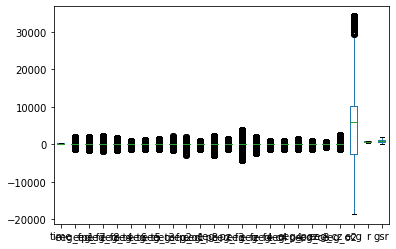

In [61]:
train_df.select_dtypes(np.float16).plot.box()

In [79]:
pp.ProfileReport(train_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,28
Number of observations,4867421
Total Missing (%),0.0%
Total size in memory,1.0 GiB
Average record size in memory,224.0 B
Numeric,25
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [0]:
train_ds.set_index(['crew', 'seat', 'experiment']).plot().head()

time   eeg_fp1  ...         gsr  event
crew seat experiment                      ...                   
1    1    CA          0.011719  -5.28545  ...  388.829987      A
          CA          0.015625  -2.42842  ...  388.829987      A
          CA          0.019531  10.67150  ...  388.829987      A
          CA          0.023438  11.45250  ...  388.829987      A
          CA          0.027344   7.28321  ...  388.829987      A

[5 rows x 25 columns]